# The notebook contains
### Code for _Bulyan_ aggregation algorithm
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Hizan\AppData\Local\Temp\ipykernel_6492\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp

sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

## Get cifar10 data and split it in IID fashion

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)

X=[]
Y=[]
for i in range(len(cifar10_train)):
    X.append(cifar10_train[i][0].numpy())
    Y.append(cifar10_train[i][1])

for i in range(len(cifar10_test)):
    X.append(cifar10_test[i][0].numpy())
    Y.append(cifar10_test[i][1])

X=np.array(X)
Y=np.array(Y)

print('total data len: ',len(X))

if not os.path.isfile('./cifar10_shuffle.pkl'):
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))
else:
    all_indices=pickle.load(open('./cifar10_shuffle.pkl','rb'))

X=X[all_indices]
Y=Y[all_indices]

Files already downloaded and verified
Files already downloaded and verified
total data len:  60000


## Divide cifar10 data among 50 clients in IID fashion

In [4]:
# data loading

nusers=50
user_tr_len=1000

total_tr_len=user_tr_len*nusers
val_len=5000
te_len=5000

print('total data len: ',len(X))

if not os.path.isfile('./cifar10_shuffle.pkl'):
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))
else:
    all_indices=pickle.load(open('./cifar10_shuffle.pkl','rb'))

total_tr_data=X[:total_tr_len]
total_tr_label=Y[:total_tr_len]

val_data=X[total_tr_len:(total_tr_len+val_len)]
val_label=Y[total_tr_len:(total_tr_len+val_len)]

te_data=X[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]
te_label=Y[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]

total_tr_data_tensor=torch.from_numpy(total_tr_data).type(torch.FloatTensor)
total_tr_label_tensor=torch.from_numpy(total_tr_label).type(torch.LongTensor)

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

print('total tr len %d | val len %d | test len %d'%(len(total_tr_data_tensor),len(val_data_tensor),len(te_data_tensor)))

#==============================================================================================================

user_tr_data_tensors=[]
user_tr_label_tensors=[]

for i in range(nusers):
    
    user_tr_data_tensor=torch.from_numpy(total_tr_data[user_tr_len*i:user_tr_len*(i+1)]).type(torch.FloatTensor)
    user_tr_label_tensor=torch.from_numpy(total_tr_label[user_tr_len*i:user_tr_len*(i+1)]).type(torch.LongTensor)

    user_tr_data_tensors.append(user_tr_data_tensor)
    user_tr_label_tensors.append(user_tr_label_tensor)
    print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

total data len:  60000
total tr len 50000 | val len 5000 | test len 5000
user 0 tr len 1000
user 1 tr len 1000
user 2 tr len 1000
user 3 tr len 1000
user 4 tr len 1000
user 5 tr len 1000
user 6 tr len 1000
user 7 tr len 1000
user 8 tr len 1000
user 9 tr len 1000
user 10 tr len 1000
user 11 tr len 1000
user 12 tr len 1000
user 13 tr len 1000
user 14 tr len 1000
user 15 tr len 1000
user 16 tr len 1000
user 17 tr len 1000
user 18 tr len 1000
user 19 tr len 1000
user 20 tr len 1000
user 21 tr len 1000
user 22 tr len 1000
user 23 tr len 1000
user 24 tr len 1000
user 25 tr len 1000
user 26 tr len 1000
user 27 tr len 1000
user 28 tr len 1000
user 29 tr len 1000
user 30 tr len 1000
user 31 tr len 1000
user 32 tr len 1000
user 33 tr len 1000
user 34 tr len 1000
user 35 tr len 1000
user 36 tr len 1000
user 37 tr len 1000
user 38 tr len 1000
user 39 tr len 1000
user 40 tr len 1000
user 41 tr len 1000
user 42 tr len 1000
user 43 tr len 1000
user 44 tr len 1000
user 45 tr len 1000
user 46 tr len 10

## Code for Bulyan aggregation algorithm

In [5]:
def bulyan(all_updates, n_attackers):
    nusers = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (nusers - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## Code for Multi-krum aggregation algorithm

In [6]:
def multi_krum(all_updates, n_attackers, multi_k=False):
    # print("all_updates.shape: ", all_updates.shape)
    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        torch.cuda.empty_cache()                    
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    # print("candidates", len(candidates))

    aggregate = torch.mean(candidates, dim=0)

    return aggregate, np.array(candidate_indices)

## Code for our AGR-tailored attack on Bulyan
* Note that our attacks on multi-krum and Bulyan aggregations are the same

In [11]:
def projection(mal_update, all_updates, deviation, n_attacker):
    d_best = 999999999
    gamma_best = 1
    mal_update = (mal_update * deviation) / torch.sum(mal_update.abs())
    agg_grads, krum_candidate = multi_krum(all_updates[n_attacker:], 0, multi_k=True)
    
    for gamma in range(20, 30):
        new_mal_update = gamma * mal_update
        new_mal_updates = torch.stack([new_mal_update] * n_attacker)
        new_mal_updates = torch.cat((new_mal_updates, all_updates[n_attacker:]), 0)
        temp_agg_grads, temp_krum_candidate = multi_krum(new_mal_updates, n_attacker, multi_k=True)

        d = torch.sum(torch.abs(temp_agg_grads - agg_grads))
        if d < d_best:
            gamma_best = gamma
            d = d_best
    print("gamma: ", gamma)
    return gamma_best * mal_update

In [12]:
def projection2(mal_update, all_updates, deviation, n_attacker):
    A = all_updates[n_attacker:]
    A_T = torch.transpose(all_updates[n_attacker:])
    return A_T @ torch.inverse(A @ A_T,) @ A @ mal_update

In [13]:
def our_attack_mkrum(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)

    lamda = torch.Tensor([3.0]).cuda()

    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        mal_updates = torch.stack([mal_update] * n_attackers)
        mal_updates = torch.cat((mal_updates, all_updates), 0)

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=True)
        if np.sum(krum_candidate < n_attackers) == n_attackers:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)
    mal_update = projection(mal_update, all_updates, deviation, n_attacker)
    
    mal_updates = torch.stack([mal_update] * n_attackers)
    mal_updates = torch.cat((mal_updates, all_updates), 0)

    return mal_updates

3## Execute our AGR-tailored attack on Bulyan

In [14]:
batch_size=250
resume=0
nepochs= 500 
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
z=0
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(n_attacker, nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        malicious_grads = user_grads

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            # agg_grads = torch.mean(malicious_grads, 0)
            # deviation = torch.mean(malicious_grads, 0)/ torch.norm(agg_grads)
            # print("deviation.shape: ", deviation.shape)
            # gamma_best, mal_update = projection(malicious_grads[0], malicious_grads, deviation, n_attacker)
            # print(gamma_best)
            if at_type == 'lie':
                malicious_grads = get_malicious_updates_lie(malicious_grads, n_attacker, z, epoch_num)
            elif at_type == 'fang':
                agg_grads = torch.mean(malicious_grads, 0)
                deviation = torch.sign(agg_grads)
                malicious_grads = get_malicious_updates_fang(malicious_grads, agg_grads, deviation, n_attacker)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(malicious_grads, 0)
                malicious_grads = our_attack_mkrum(malicious_grads, agg_grads, n_attacker, dev_type=dev_type)

        if aggregation=='median':
            agg_grads=torch.median(malicious_grads,dim=0)[0]

        elif aggregation=='average':
            agg_grads=torch.mean(malicious_grads,dim=0)

        elif aggregation=='krum' or aggregation=='mkrum':

            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation=='bulyan':
            agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./projection.csv', index=False)从v 

            
        epoch_num+=1

gamma:  29
epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3024 val acc 10.2881 best val_acc 10.288149


C:\Users\Hizan\AppData\Local\Temp\ipykernel_6492\1126686736.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


gamma:  29
epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3022 val acc 10.2881 best val_acc 10.288149
gamma:  29
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3020 val acc 10.2881 best val_acc 10.288149
gamma:  29
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3017 val acc 10.4505 best val_acc 10.450487
gamma:  29
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3014 val acc 10.7752 best val_acc 10.775162
gamma:  29
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.3012 val acc 11.0187 best val_acc 11.018669
gamma:  29
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.3009 val acc 11.1607 best val_acc 11.160714
gamma:  29
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.3006 val acc 12.0942 best val_acc 12.094156
gamma:  29
epoch: 8, bulyan: at our-agr n_at 10 e 8 | val loss 2.3004 val acc 12.7841 best val_acc 12.784091
gamma:  29
epoch: 9, bulyan: at our-agr n_at 10 e 9 | val loss 2.3001 val acc 12.9667 best val_acc 12.966721
gamma:  29
epoch: 1

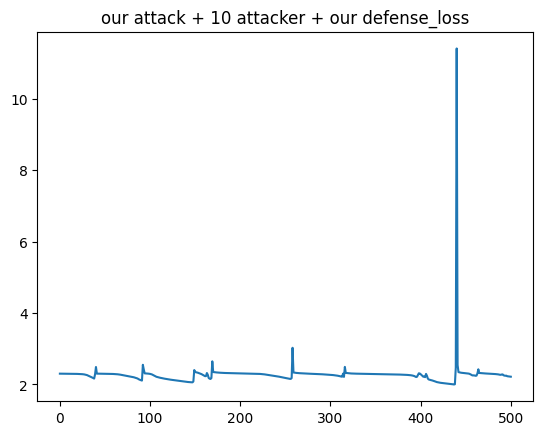

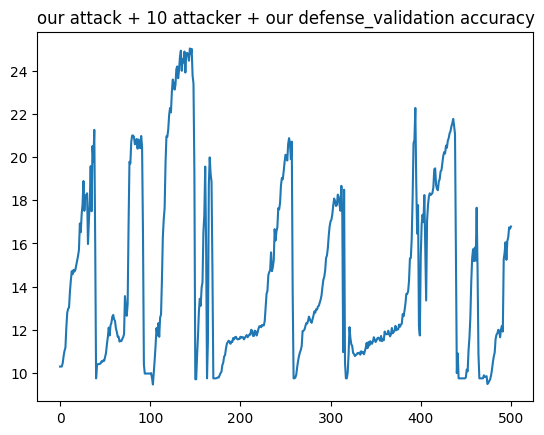

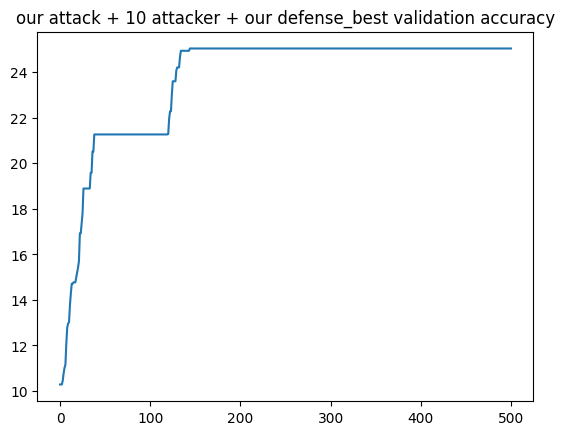

In [15]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./projection_' + col + '.png')
    plt.show()

In [16]:
def our_attack_mkrum(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)

    lamda = torch.Tensor([3.0]).cuda()

    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        mal_updates = torch.stack([mal_update] * n_attackers)
        mal_updates = torch.cat((mal_updates, all_updates), 0)

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=True)
        if np.sum(krum_candidate < n_attackers) == n_attackers:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)
    
    mal_updates = torch.stack([mal_update] * n_attackers)
    mal_updates = torch.cat((mal_updates, all_updates), 0)

    return mal_updates

In [17]:
batch_size=250
resume=0
nepochs= 500
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
z=0
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(n_attacker, nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        malicious_grads = user_grads

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            # agg_grads = torch.mean(malicious_grads, 0)
            # deviation = torch.mean(malicious_grads, 0)/ torch.norm(agg_grads)
            # print("deviation.shape: ", deviation.shape)
            # gamma_best, mal_update = projection(malicious_grads[0], malicious_grads, deviation, n_attacker)
            # print(gamma_best)
            if at_type == 'lie':
                malicious_grads = get_malicious_updates_lie(malicious_grads, n_attacker, z, epoch_num)
            elif at_type == 'fang':
                agg_grads = torch.mean(malicious_grads, 0)
                deviation = torch.sign(agg_grads)
                malicious_grads = get_malicious_updates_fang(malicious_grads, agg_grads, deviation, n_attacker)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(malicious_grads, 0)
                malicious_grads = our_attack_mkrum(malicious_grads, agg_grads, n_attacker, dev_type=dev_type)

        if aggregation=='median':
            agg_grads=torch.median(malicious_grads,dim=0)[0]

        elif aggregation=='average':
            agg_grads=torch.mean(malicious_grads,dim=0)

        elif aggregation=='krum' or aggregation=='mkrum':

            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation=='bulyan':
            agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./regular.csv', index=False)

            
        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3025 val acc 9.9635 best val_acc 9.963474


C:\Users\Hizan\AppData\Local\Temp\ipykernel_6492\1029785652.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3019 val acc 9.9635 best val_acc 9.963474
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3011 val acc 9.9635 best val_acc 9.963474
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3001 val acc 9.9635 best val_acc 9.963474
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.2990 val acc 9.9635 best val_acc 9.963474
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.2976 val acc 10.0244 best val_acc 10.024351
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.2961 val acc 9.9635 best val_acc 10.024351
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.2936 val acc 10.2070 best val_acc 10.206981
epoch: 8, bulyan: at our-agr n_at 10 e 8 | val loss 2.2904 val acc 10.1461 best val_acc 10.206981
epoch: 9, bulyan: at our-agr n_at 10 e 9 | val loss 2.2860 val acc 10.3287 best val_acc 10.328734
epoch: 10, bulyan: at our-agr n_at 10 e 10 | val loss 2.2802 val acc 10.0852 best val_acc 10.328734
epoch: 11, bulyan: at our-a

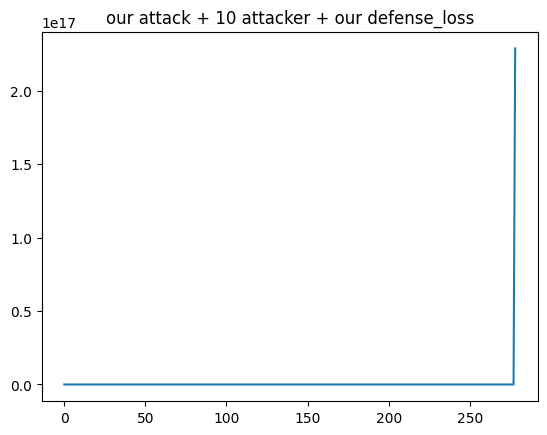

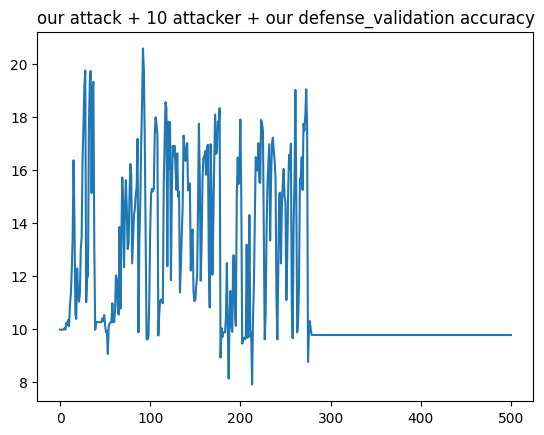

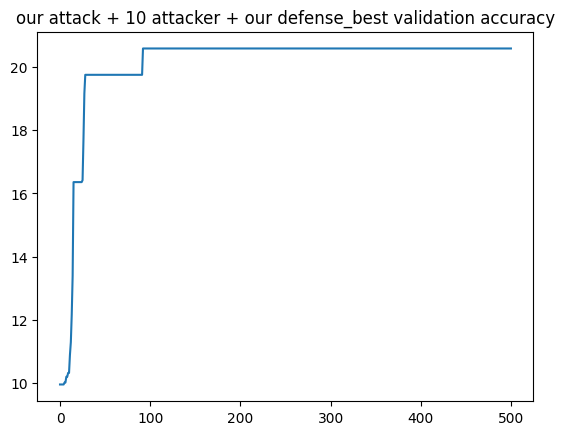

In [18]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./regular_' + col + '.png')
    plt.show()